In [60]:
%load_ext autoreload
%autoreload 2

import os
import sys
from pathlib import Path
import random

import pandas as pd
import numpy as np
import torch

sys.path.append(os.path.abspath('..'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

seed = 123456

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
sequence_length = 24
batch_size = 32

In [62]:
from crypto_price_analysis import BinanceDataset

binance_dataset = BinanceDataset(Path("../data"), "ETHUSDT", "15m", sequence_length + 1)

binance_dataset.download_binance_dataset()
data_chunks, mean, std = binance_dataset.preprocess_binance_dataset()

Failed to dowload https://data.binance.vision/data/spot/monthly/klines/ETHUSDT/15m/ETHUSDT-15m-2024-07.zip


In [63]:
from crypto_price_analysis.dataset import ChunkedSequenceDataset
from torch.utils.data import DataLoader, SubsetRandomSampler

def dataframe_to_tensor(dataframe: pd.DataFrame | pd.Series, torch_device=device):
    return torch.Tensor(dataframe.values.astype(np.float32)).to(torch_device)

dataset = ChunkedSequenceDataset(list(map(dataframe_to_tensor, data_chunks)), sequence_length)

In [64]:
dataset_size = len(dataset)
testset_size = 4 * 24 * 7

testset_X, testset_y = zip(*[dataset[i] for i in range(dataset_size - testset_size, dataset_size)])
testset_X = torch.stack(testset_X)
testset_y = torch.stack(testset_y)

valset_size = int(0.05 * (dataset_size - testset_size))
trainset_size = dataset_size - testset_size - valset_size

indices = np.arange(dataset_size - testset_size, dtype=int)
np.random.shuffle(indices)

val_indices, train_indices = indices[:valset_size], indices[valset_size:]

val_sampler = SubsetRandomSampler(val_indices.tolist())
train_sampler = SubsetRandomSampler(train_indices.tolist())

val_loader = DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)

print(trainset_size, valset_size, testset_size)

231126 12164 672


In [65]:
import math
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float, max_len: int = 1000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, d_model, 2)* math.log(10000) / d_model)
        pos = torch.arange(0, max_len).reshape(max_len, 1)
        pos_encoding = torch.zeros((max_len, d_model))
        pos_encoding[:, 0::2] = torch.sin(pos * den)
        pos_encoding[:, 1::2] = torch.cos(pos * den)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_encoding', pos_encoding)

    def forward(self, x: torch.Tensor):
        return self.dropout(x + self.pos_encoding[:x.size(1), :])

In [66]:
class ReturnsForecast(nn.Module):

    def __init__(self, d_model, nhead, num_layers, dropout):
        super(ReturnsForecast, self).__init__()
        self.linear1 = nn.Linear(7, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout, 1000)
        # self.register_buffer('causal_mask', causal_mask)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.linear2 = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = self.positional_encoding(x)
        causal_mask = nn.Transformer.generate_square_subsequent_mask(x.size(1)).to(x.device)
        x = self.transformer_encoder(x, mask=causal_mask, is_causal=True)
        return self.linear2(x[:, -1, :])
    

In [67]:
retrain_model = True

In [68]:
from crypto_price_analysis.train import train_model

model = ReturnsForecast(d_model=32, nhead=4, num_layers=4, dropout=0.2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.98)
loss_function = nn.MSELoss()

model_path = '../model/transformer-model.h5'
if retrain_model or not Path(model_path).exists():
    train_loss_history, val_loss_history = train_model(model, train_loader, val_loader, optimizer, loss_function, 100, scheduler)
    torch.save(model.state_dict(), model_path)
else:
    model.load_state_dict(torch.load(model_path, weights_only=True))

epoch:    0 duration: 68.16s loss: 1.00235 val_loss: 1.01210
epoch:    1 duration: 66.06s loss: 1.00038 val_loss: 1.01265
epoch:    2 duration: 64.70s loss: 1.00072 val_loss: 1.01196
epoch:    3 duration: 67.37s loss: 1.00064 val_loss: 1.01263
epoch:    4 duration: 68.63s loss: 1.00048 val_loss: 1.02948
epoch:    5 duration: 67.81s loss: 1.00050 val_loss: 1.01964
epoch:    6 duration: 65.16s loss: 1.00013 val_loss: 1.01185
epoch:    7 duration: 65.03s loss: 1.00028 val_loss: 1.01196
epoch:    8 duration: 69.70s loss: 1.00001 val_loss: 1.01541
epoch:    9 duration: 68.97s loss: 1.00017 val_loss: 1.01302
epoch:   10 duration: 70.71s loss: 0.99989 val_loss: 1.01803
epoch:   11 duration: 68.21s loss: 0.99995 val_loss: 1.01250
epoch:   12 duration: 72.30s loss: 1.00022 val_loss: 1.01187
epoch:   13 duration: 69.77s loss: 0.99998 val_loss: 1.01372
epoch:   14 duration: 69.52s loss: 0.99998 val_loss: 1.02162
epoch:   15 duration: 69.88s loss: 0.99948 val_loss: 1.01258
epoch:   16 duration: 68

In [69]:
import typing
import collections.abc

model.eval()
counts = np.array([0, 0])
running_loss = 0

with torch.no_grad():
    for x, y in train_loader:
        y_pred = model(x)

        y_pred_untransformed = torch.expm1(y_pred * std.iloc[3] + mean.iloc[3])
        y_untransformed = torch.expm1(y * std.iloc[3] + mean.iloc[3])

        running_loss += nn.functional.l1_loss(y_pred_untransformed, y_untransformed) * x.size(0)

        score = np.where((y_pred_untransformed * y_untransformed).cpu() > 0, 1, 0)
        unique, count = np.unique(score, return_counts=True)
        counts[unique] += count

print(f'accuracy: {counts[1] / (counts[0] + counts[1])} mae: {running_loss / len(typing.cast(collections.abc.Sized, train_loader.sampler))}') 
print(counts)

accuracy: 0.5014191393439077 mae: 0.003037606133148074
[115235 115891]


In [70]:
model.eval()
with torch.no_grad():
    y_pred = model(testset_X)

    y_pred_untransformed = torch.expm1(y_pred * std.iloc[3] + mean.iloc[3])
    y_untransformed = torch.expm1(testset_y * std.iloc[3] + mean.iloc[3])

    loss = nn.functional.l1_loss(y_pred_untransformed, y_untransformed)

score = np.where((y_pred_untransformed * y_untransformed).cpu() > 0, 1, 0)
unique, counts = np.unique(score, return_counts=True)

print(f'accuracy: {counts[1] / (counts[0] + counts[1])} mae: {loss}') 
print(counts)

accuracy: 0.47470238095238093 mae: 0.0037904568016529083
[353 319]


In [71]:
backtest = data_chunks[-1][['close']][-testset_size:] 
backtest['close'] = np.expm1(backtest['close'] * std.iloc[3] + mean.iloc[3])
backtest

,close
open_time,
2024-07-30 00:00:00,-0.001706
2024-07-30 00:15:00,-0.001570
2024-07-30 00:30:00,0.003387
2024-07-30 00:45:00,0.003104
2024-07-30 01:00:00,0.001896
...,...
2024-08-05 22:45:00,0.000910
2024-08-05 23:00:00,0.001847
2024-08-05 23:15:00,-0.005998


In [72]:
with torch.no_grad():
    backtest['pred'] = model(testset_X).cpu()
backtest['pred'] = np.expm1(backtest['pred'] * std.iloc[3] + mean.iloc[3])

In [73]:
backtest

,close,pred
open_time,,
2024-07-30 00:00:00,-0.001706,0.000079
2024-07-30 00:15:00,-0.001570,0.000079
2024-07-30 00:30:00,0.003387,0.000079
2024-07-30 00:45:00,0.003104,0.000079
2024-07-30 01:00:00,0.001896,0.000079
...,...,...
2024-08-05 22:45:00,0.000910,0.000079
2024-08-05 23:00:00,0.001847,0.000079
2024-08-05 23:15:00,-0.005998,0.000079


In [74]:
backtest['pred_sign'] = np.sign(backtest['pred'])
backtest['returns'] = backtest['pred_sign'] * backtest['close']

0.7293061977417802

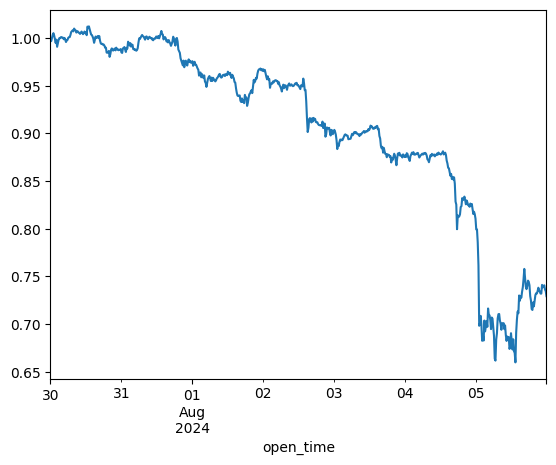

In [75]:
(backtest['returns'] + 1).cumprod().plot()
(backtest['returns'] + 1).prod()

0.7293061977417802

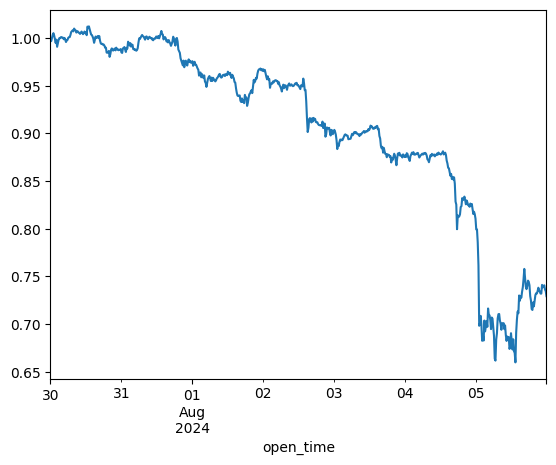

In [76]:
(backtest['close'] + 1).cumprod().plot()
(backtest['close'] + 1).prod()